# Machine Learning Engineer Nanodegree
## Capstone Project - Starbucks app data

In [1]:
import os
import numpy as np
import pandas as pd
import pprint
import json

from IPython.display import display
from lib.utils import assess_model

%load_ext autoreload
%autoreload 2

In [2]:
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker import LinearLearner
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner, CategoricalParameter
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

b_session = boto3.session.Session(region_name='eu-central-1')

session = sagemaker.Session(boto_session=b_session)
role = 'AmazonSageMaker-ExecutionRole-20191105T072928'

bucket = session.default_bucket()

# Part 4 - Data preprocessing

Before running some Machine Learning models, we have to go through some preparation steps on the data, as
- impute missing values
- encode categorical variables (*gender*)
- normalize feature distributions

To do so, we use the classical **scikit-learn** API and the **SKLearnProcessor** feature of AWS Sagemaker to run the job on the cloud.

In [4]:
output_configs = {}

for tgt in ['bogo', 'discount', 'info']:
    print(tgt)
    
    sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                         role=role,
                                         instance_type='ml.m5.xlarge',
                                         instance_count=1)
    sklearn_processor.run(
        code='lib/preprocessing.py', #entrypoint for processing
        inputs=[ProcessingInput(os.path.join('s3://', bucket, f'Capstone_Starbucks/{tgt}.csv'), '/opt/ml/processing/input')],
        outputs=[
            ProcessingOutput(source=f'/opt/ml/processing/output/',
                             output_name=f'{tgt}_data')
        ],
        arguments=['--target', tgt]
     )

    preprocessing_job_description = sklearn_processor.jobs[-1].describe()
    output_configs[tgt] = preprocessing_job_description['ProcessingOutputConfig']

bogo

Job Name:  sagemaker-scikit-learn-2020-01-18-17-19-28-554
Inputs:  [{'InputName': 'input-1', 'S3Input': {'S3Uri': 's3://sagemaker-eu-central-1-601949536922/Capstone_Starbucks/bogo.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'S3Input': {'S3Uri': 's3://sagemaker-eu-central-1-601949536922/sagemaker-scikit-learn-2020-01-18-17-19-28-554/input/code/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'bogo_data', 'S3Output': {'S3Uri': 's3://sagemaker-eu-central-1-601949536922/sagemaker-scikit-learn-2020-01-18-17-19-28-554/output/bogo_data', 'LocalPath': '/opt/ml/processing/output/', 'S3UploadMode': 'EndOfJob'}}]
....................Collecting joblib
  Found existing installation

In [5]:
preprocessed_data = {}
for output in output_configs:
            preprocessed_data[output] = output_configs[output]['Outputs'][0]['S3Output']['S3Uri']

In [6]:
s3_client = boto3.client('s3')
for k in preprocessed_data:
    for f in ['train.csv', 'val.csv', 'test.csv', 'test_tgt.csv', 'transformer.joblib']:
        copy_source = {'Bucket': bucket, 'Key': '/'.join(preprocessed_data[k][5:].split('/')[1:] + [f'{k}_{f}'])}
        s3_client.copy_object(CopySource=copy_source, Bucket=bucket, Key=f'Capstone_Starbucks/{k}/{k}_{f}')

In [7]:
for k in preprocessed_data:
    for f in ['train.csv', 'val.csv', 'test.csv', 'test_tgt.csv']:
        session.download_data(f'./data/{k}/', bucket, f'Capstone_Starbucks/{k}/{k}_{f}')

# Part 5 - Machine Learning models

In [10]:
best_model = {'bogo': {}, 'discount': {}, 'info': {}}

## XGBoost model

In [15]:
container = get_image_uri(session.boto_region_name, 'xgboost', '0.90-1')

for prefix in ['info']:# ['bogo', 'discount', 'info']:


    xgb = sagemaker.estimator.Estimator(container,
                                        role,
                                        train_instance_count=1,
                                        train_instance_type='ml.c4.xlarge',
                                        output_path=f's3://{bucket}/Capstone_Starbucks/{prefix}/model',
                                        sagemaker_session=session,
                                        base_job_name=prefix + '-')


    xgb.set_hyperparameters(max_depth=4,
                            eta=0.1,
                            gamma=4,
                            min_child_weight=6,
                            colsample_bytree=0.5,
                            subsample=0.6,
                            early_stopping_rounds=10,
                            num_round=200,
                            seed=1123)


    

    xgb_hyperparameter_tuner = HyperparameterTuner(estimator=xgb,
                                                   objective_metric_name='validation:f1',
                                                   objective_type='Maximize',
                                                   max_jobs=20,
                                                   max_parallel_jobs=4,
                                                   hyperparameter_ranges = {
                                                        'max_depth': IntegerParameter(2, 6),
                                                        'eta'      : ContinuousParameter(0.01, 0.5),
                                                        'gamma': ContinuousParameter(0, 10),
                                                        'min_child_weight': IntegerParameter(2, 8),
                                                        'colsample_bytree': ContinuousParameter(0.2, 1.0),
                                                        'subsample': ContinuousParameter(0.3, 1.0),
                                                   },
                                                   base_tuning_job_name=prefix + '-xgb-tuning')

    # This is a wrapper around the location of our train and validation data, to make sure that SageMaker
    # knows our data is in csv format.
    s3_input_train = sagemaker.s3_input(s3_data=f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_train.csv', content_type='csv')
    s3_input_validation = sagemaker.s3_input(s3_data=f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_val.csv', content_type='csv')

    xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})
    
    print(f'Waiting {prefix}...')
    xgb_hyperparameter_tuner.wait()

    best_model[prefix]['xgb'] = {'name': xgb_hyperparameter_tuner.best_training_job(),
                                 'value': xgb_hyperparameter_tuner.analytics().dataframe()['FinalObjectiveValue'].max()}

Waiting info...
..................................................................................................................................................................................................................!


### Linear Learner 

In [11]:
container = get_image_uri(session.boto_region_name, 'linear-learner')
for prefix in ['bogo', 'discount', 'info']:


    ll = LinearLearner(role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='binary_classifier',
                       output_path='s3://{}/Capstone_Starbucks/{}/model'.format(bucket, prefix),
                       sagemaker_session=session,
                       binary_classifier_model_selection_criteria='f1',
                       epochs=100,
                       use_bias=True,
                       optimizer='adam',
                       loss='auto',
                       wd=0,
                       normalize_data=True,
                       unbias_data=True,
                       early_stopping_patience=5,
                       learning_rate=0.01,
                       balance_multiclass_weights=True)
    
    train = pd.read_csv(f'./data/{prefix}/{prefix}_train.csv', header=None)
    train_data = ll.record_set(train.drop(0, 1).values.astype('float32'), labels=train[0].values.astype('float32'),
                                         channel='train')
    
    valid = pd.read_csv(f'./data/{prefix}/{prefix}_train.csv', header=None)
    validation_data = ll.record_set(valid.drop(0, 1).values.astype('float32'), labels=valid[0].values.astype('float32'),
                                         channel='validation')

    # This is a wrapper around the location of our train and validation data, to make sure that SageMaker
    # knows our data is in csv format.

    ll.fit([train_data, validation_data], logs=False)

    tja = ll.training_job_analytics
    res = tja.dataframe()
    best_model[prefix]['ll'] = {'name': tja.name,
                                'value': res.loc[res['metric_name'] == 'validation:binary_f_beta', 'value'].values[0]}


2020-01-18 17:35:36 Starting - Starting the training job
2020-01-18 17:35:37 Starting - Launching requested ML instances...........
2020-01-18 17:36:37 Starting - Preparing the instances for training..........
2020-01-18 17:37:34 Downloading - Downloading input data...
2020-01-18 17:37:57 Training - Downloading the training image..
2020-01-18 17:38:09 Training - Training image download completed. Training in progress..........................
2020-01-18 17:40:22 Uploading - Uploading generated training model
2020-01-18 17:40:29 Completed - Training job completed


2020-01-18 17:40:54 Starting - Starting the training job
2020-01-18 17:40:56 Starting - Launching requested ML instances...........
2020-01-18 17:41:56 Starting - Preparing the instances for training..............
2020-01-18 17:43:12 Downloading - Downloading input data..
2020-01-18 17:43:28 Training - Downloading the training image..
2020-01-18 17:43:41 Training - Training image download completed. Training in progress..................
2020-01-18 17:45:13 Uploading - Uploading generated training model
2020-01-18 17:45:19 Completed - Training job completed



2020-01-18 17:45:28 Starting - Starting the training job
2020-01-18 17:45:29 Starting - Launching requested ML instances...........
2020-01-18 17:46:30 Starting - Preparing the instances for training......
2020-01-18 17:47:07 Downloading - Downloading input data.......
2020-01-18 17:47:48 Training - Downloading the training image
2020-01-18 17:48:01 Training - Training image download completed. Training in progress..............
2020-01-18 17:49:19 Uploading - Uploading generated training model
2020-01-18 17:49:19 Completed - Training job completed


In [16]:
pprint.pprint(best_model)

{'bogo': {'ll': {'name': 'linear-learner-2020-01-18-17-35-31-861',
                 'value': 0.713481285194},
          'xgb': {'name': 'bogo-xgb-tuning-200118-1924-019-e8b5e6f6',
                  'value': 0.7396870255470276}},
 'discount': {'ll': {'name': 'linear-learner-2020-01-18-17-40-34-434',
                     'value': 0.709247431269},
              'xgb': {'name': 'discount-xgb-tuning-200118-2242-018-7ec3639a',
                      'value': 0.7281720042228699}},
 'info': {'ll': {'name': 'linear-learner-2020-01-18-17-45-27-216',
                 'value': 0.691518566681},
          'xgb': {'name': 'info-xgb-tuning-200119-0118-011-3134378f',
                  'value': 0.6660270094871521}}}


It seems that for **bogo** and **discount** offers, the best model is XGBoost; for **informational** instead we should go with the LinearLearner. Let's look at the performances on the *test set*.

In [ ]:
models = {}
transformers = {}

for prefix in ['bogo','discount', 'info']:
    print(prefix)
    
    if prefix == 'info':
        models[prefix] = sagemaker.estimator.Estimator.attach(best_model[prefix]['ll']['name'])
    else:
        models[prefix] = sagemaker.estimator.Estimator.attach(best_model[prefix]['xgb']['name'])

    transformers[prefix] = models[prefix].transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

    transformers[prefix].transform(f's3://{bucket}/Capstone_Starbucks/{prefix}/{prefix}_test.csv',
                                       content_type='text/csv', split_type='Line', wait=True, logs=False)

#    transformers[prefix].wait(logs=False)

    session.download_data(f'./data/{prefix}_preds', bucket,
                          key_prefix='/'.join(transformers[prefix].output_path.split('/')[3:]))

In [27]:
jsons

[0.33982759714126587,
 0.442009299993515,
 0.5476248264312744,
 0.442009299993515,
 0.5661447644233704,
 0.5016160011291504,
 0.5016160011291504,
 0.5016160011291504,
 0.574459969997406,
 0.574459969997406,
 0.5016160011291504,
 0.5916283130645752,
 0.43865883350372314,
 0.442009299993515,
 0.442009299993515,
 0.49553319811820984,
 0.5016160011291504,
 0.3297455310821533,
 0.5016160011291504,
 0.574459969997406,
 0.4482152760028839,
 0.5016160011291504,
 0.49553319811820984,
 0.48638296127319336,
 0.5916283130645752,
 0.5916283130645752,
 0.49553319811820984,
 0.574459969997406,
 0.5916283130645752,
 0.5476248264312744,
 0.5916283130645752,
 0.442009299993515,
 0.48638296127319336,
 0.442009299993515,
 0.442009299993515,
 0.442009299993515,
 0.46714022755622864,
 0.5476248264312744,
 0.5916283130645752,
 0.5916283130645752,
 0.49553319811820984,
 0.43865883350372314,
 0.442009299993515,
 0.49553319811820984,
 0.442009299993515,
 0.5016160011291504,
 0.49553319811820984,
 0.448215276002

bogo


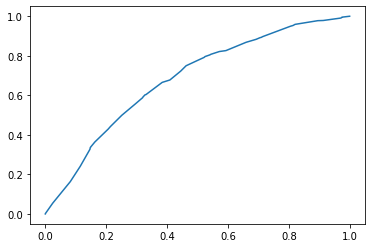

col_0,0,1
0,,
0.0,0.669159,0.330841
1.0,0.396262,0.603738


,value
accuracy,0.636449
balanced_accuracy,0.636449
precision,0.646000
recall,0.603738
f1,0.624155
average_precision,0.638275
AUC,0.681219




discount


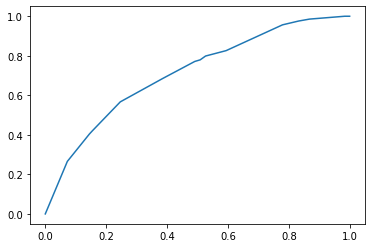

col_0,0,1
0,,
0.0,0.615137,0.384863
1.0,0.315620,0.684380


,value
accuracy,0.649758
balanced_accuracy,0.649758
precision,0.640060
recall,0.684380
f1,0.661479
average_precision,0.680164
AUC,0.712180




info


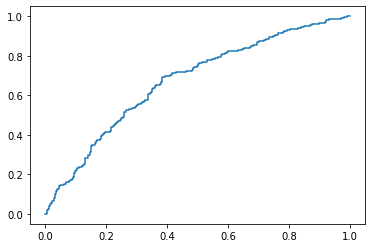

col_0,0.0,1.0
0,,
0.0,0.189560,0.810440
1.0,0.066116,0.933884


,value
accuracy,0.561210
balanced_accuracy,0.561722
precision,0.534700
recall,0.933884
f1,0.680040
average_precision,0.642018
AUC,0.671064


In [28]:
for prefix in ['bogo', 'discount', 'info']:
    print(prefix)
    y_test = pd.read_csv(f'./data/{prefix}/{prefix}_test_tgt.csv', squeeze=True, header=None)
    if prefix == 'info':
        with open(f'./data/{prefix}_preds/{prefix}_test.csv.out', 'r') as f:
            jsons = [json.loads(x.replace('\n', '')) for x in f.readlines()]
        res = pd.DataFrame(jsons)
        display(assess_model(y_test, res['score'].values, y_pred=res['predicted_label'].values))
    else:
        y_prob = pd.read_csv(f'./data/{prefix}_preds/{prefix}_test.csv.out', squeeze=True, header=None)
        display(assess_model(y_test, y_prob))
    
    print('\n')